# Posterior uncertainties

In [1]:
"""Display the marginal uncertainties of filters and smoothers."""

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import adaptive, ivpsolve, timestep
from probdiffeq.impl import impl
from probdiffeq.solvers import calibrated, markov, solution
from probdiffeq.solvers.strategies import filters, fixedpoint
from probdiffeq.solvers.strategies.components import corrections, priors
from probdiffeq.taylor import autodiff
from probdiffeq.util.doc_util import notebook

In [2]:
plt.rcParams.update(notebook.plot_style())
plt.rcParams.update(notebook.plot_sizes())

In [3]:
if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

In [4]:
impl.select("isotropic", ode_shape=(2,))

Set an example problem.

Solve the problem on a low resolution and short time-span to achieve large uncertainty.

In [5]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra()


@jax.jit
def vf(*ys, t):  # noqa: ARG001
    """Evaluate the Lotka-Volterra vector field."""
    return f(*ys, *f_args)

## Filter

In [6]:
ibm = priors.ibm_adaptive(num_derivatives=4)
ts0 = corrections.ts0()
solver = calibrated.mle(filters.filter_adaptive(ibm, ts0))
adaptive_solver = adaptive.adaptive(solver, atol=1e-2, rtol=1e-2)

ts = jnp.linspace(t0, t0 + 2.0, endpoint=True, num=500)

In [7]:
dt0 = timestep.initial(lambda y: vf(y, t=t0), (u0,))

tcoeffs = autodiff.taylor_mode_scan(lambda y: vf(y, t=t0), (u0,), num=4)
init = solver.initial_condition(tcoeffs, output_scale=1.0)
sol = ivpsolve.solve_and_save_at(
    vf, init, save_at=ts, dt0=dt0, adaptive_solver=adaptive_solver
)

marginals = solution.calibrate(sol.marginals, output_scale=sol.output_scale)

Plot the solution

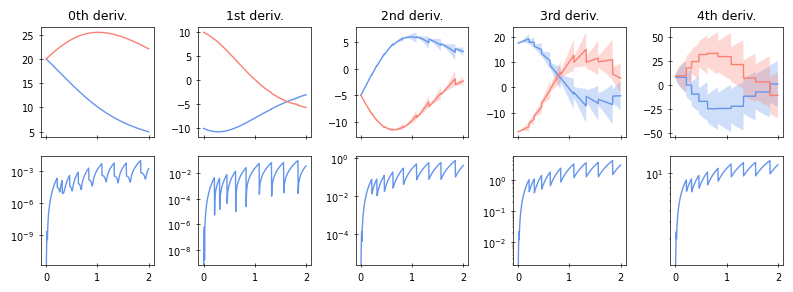

In [8]:
_, num_derivatives, _ = marginals.mean.shape


fig, axes_all = plt.subplots(
    nrows=2, ncols=num_derivatives, sharex=True, tight_layout=True, figsize=(8, 3)
)

for i, axes_cols in enumerate(axes_all.T):
    ms = marginals.mean[:, i, :]
    ls = marginals.cholesky[:, i, :]
    stds = jnp.sqrt(jnp.einsum("jn,jn->j", ls, ls))

    if i == 1:
        axes_cols[0].set_title(f"{i}st deriv.")
    elif i == 2:
        axes_cols[0].set_title(f"{i}nd deriv.")
    elif i == 3:
        axes_cols[0].set_title(f"{i}rd deriv.")
    else:
        axes_cols[0].set_title(f"{i}th deriv.")

    axes_cols[0].plot(sol.t, ms, marker="None")
    for m in ms.T:
        axes_cols[0].fill_between(sol.t, m - 1.96 * stds, m + 1.96 * stds, alpha=0.3)

    axes_cols[1].semilogy(sol.t, stds, marker="None")

plt.show()

## Smoother

In [9]:
ibm = priors.ibm_adaptive(num_derivatives=4)
ts0 = corrections.ts0()
solver = calibrated.mle(fixedpoint.fixedpoint_adaptive(ibm, ts0))
adaptive_solver = adaptive.adaptive(solver, atol=1e-2, rtol=1e-2)

ts = jnp.linspace(t0, t0 + 2.0, endpoint=True, num=500)

In [10]:
init = solver.initial_condition(tcoeffs, output_scale=1.0)
sol = ivpsolve.solve_and_save_at(
    vf, init, save_at=ts, dt0=dt0, adaptive_solver=adaptive_solver
)

marginals = solution.calibrate(sol.marginals, output_scale=sol.output_scale)
posterior = solution.calibrate(sol.posterior, output_scale=sol.output_scale)
posterior = markov.select_terminal(posterior)

In [11]:
key = jax.random.PRNGKey(seed=1)
(qoi, samples), _init = markov.sample(key, posterior, shape=(2,), reverse=True)

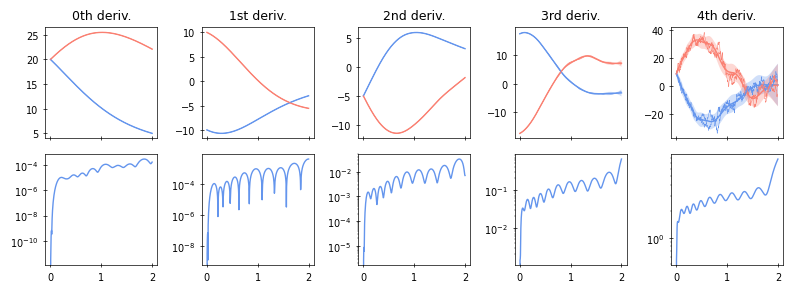

In [12]:
_, num_derivatives, _ = marginals.mean.shape


fig, axes_all = plt.subplots(
    nrows=2, ncols=num_derivatives, sharex=True, tight_layout=True, figsize=(8, 3)
)

for i, axes_cols in enumerate(axes_all.T):
    ms = marginals.mean[:, i, :]
    samps = samples[..., i, :]
    ls = marginals.cholesky[:, i, :]
    stds = jnp.sqrt(jnp.einsum("jn,jn->j", ls, ls))

    if i == 1:
        axes_cols[0].set_title(f"{i}st deriv.")
    elif i == 2:
        axes_cols[0].set_title(f"{i}nd deriv.")
    elif i == 3:
        axes_cols[0].set_title(f"{i}rd deriv.")
    else:
        axes_cols[0].set_title(f"{i}th deriv.")

    axes_cols[0].plot(sol.t, ms, marker="None")
    for s in samps:
        axes_cols[0].plot(
            sol.t[:-1], s[..., 0], color="C0", linewidth=0.35, marker="None"
        )
        axes_cols[0].plot(
            sol.t[:-1], s[..., 1], color="C1", linewidth=0.35, marker="None"
        )
    for m in ms.T:
        axes_cols[0].fill_between(sol.t, m - 1.96 * stds, m + 1.96 * stds, alpha=0.3)

    axes_cols[1].semilogy(sol.t, stds, marker="None")

plt.show()

The marginal standard deviations (bottom row) show how the filter is forward-only, whereas the smoother is a global estimate.

This is why you should use a filter for terminal-value simulation and a smoother if you want "global" solutions.